✅ (0/8) 正在设置环境并导入库...

✅ (1/8) 正在加载和清洗数据...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
数据加载成功！初始维度: (284807, 31)

正在进行预处理: 标准化 'Time' 和 'Amount' 列...
'Time' 和 'Amount' 列已完成标准化处理。

✅ (2/8) 正在进行探索性数据分析 (EDA)...


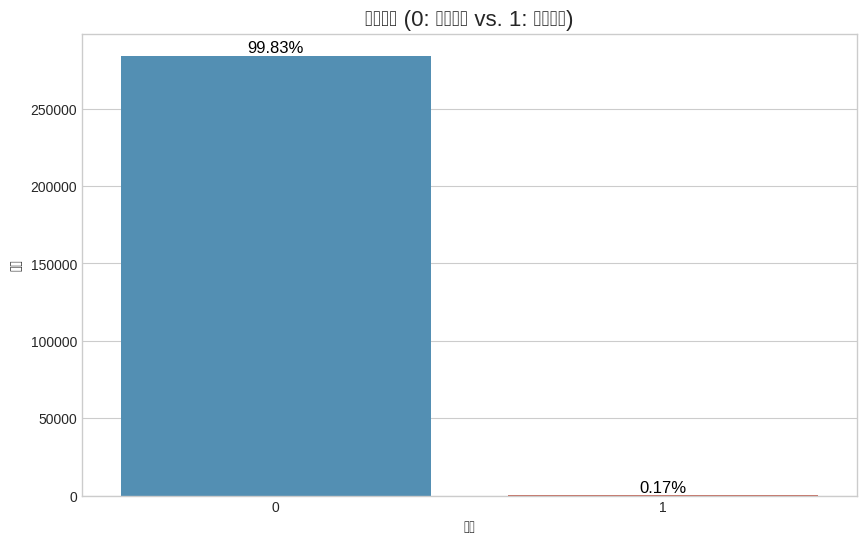

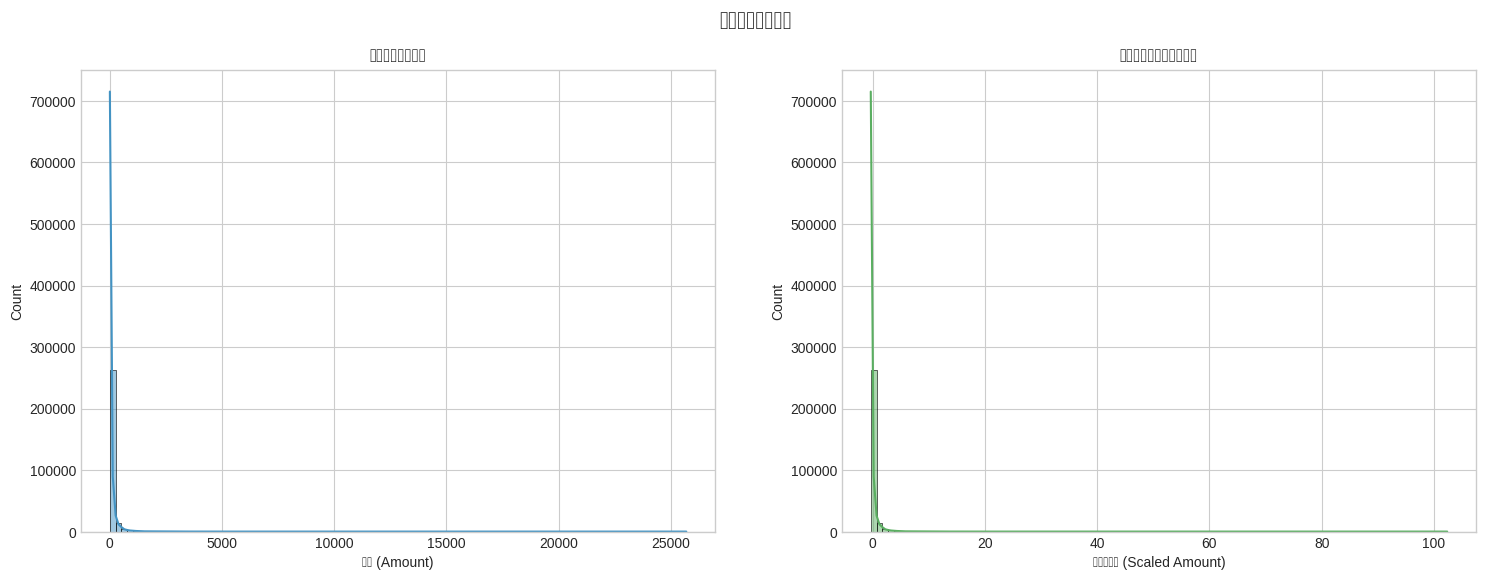


正在执行 t-SNE 降维可视化 (在5000个点的样本上)... 这可能需要一点时间。


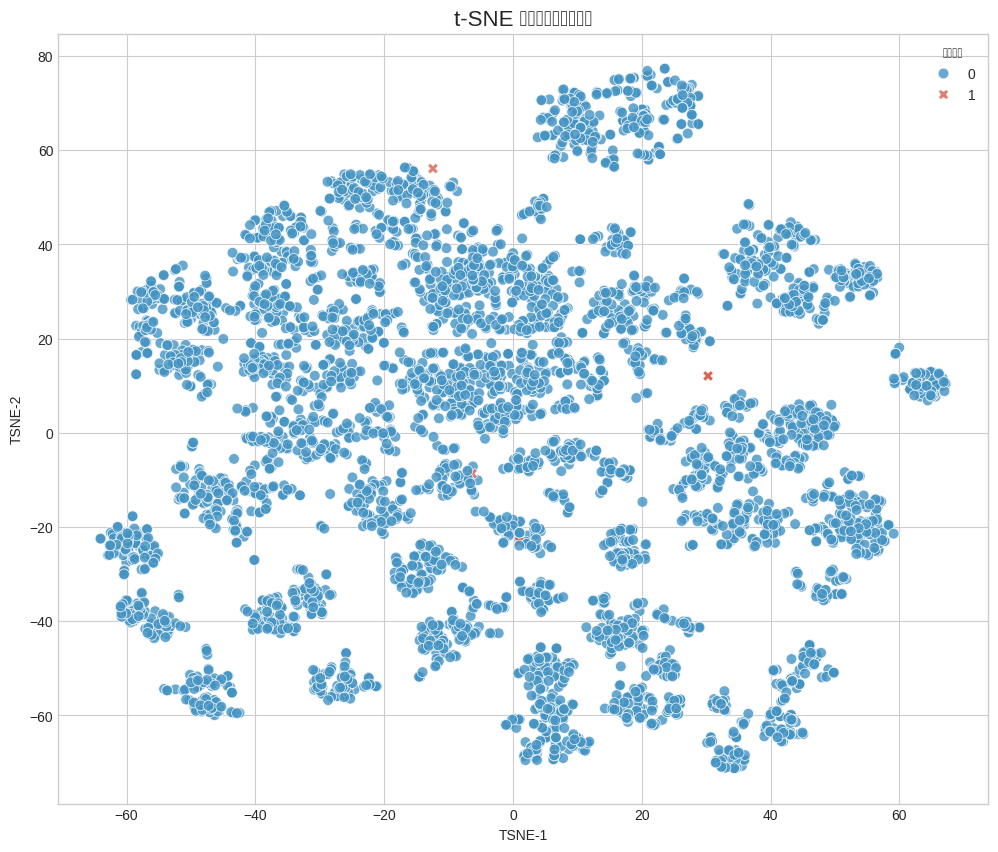


✅ (3/8) 正在划分数据集并建立基准模型...
测试集中的欺诈样本数量: 98
[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (6.95 MB) transferred to GPU in 0.008446 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339

✅ (4/8) 正在准备成本敏感学习与超参数搜索...
计算得到的 scale_pos_weight: 577.29 (欺诈样本的权重)

✅ (5/8) 正在执行超参数搜索... 这可能需要几分钟时间。
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[Ligh

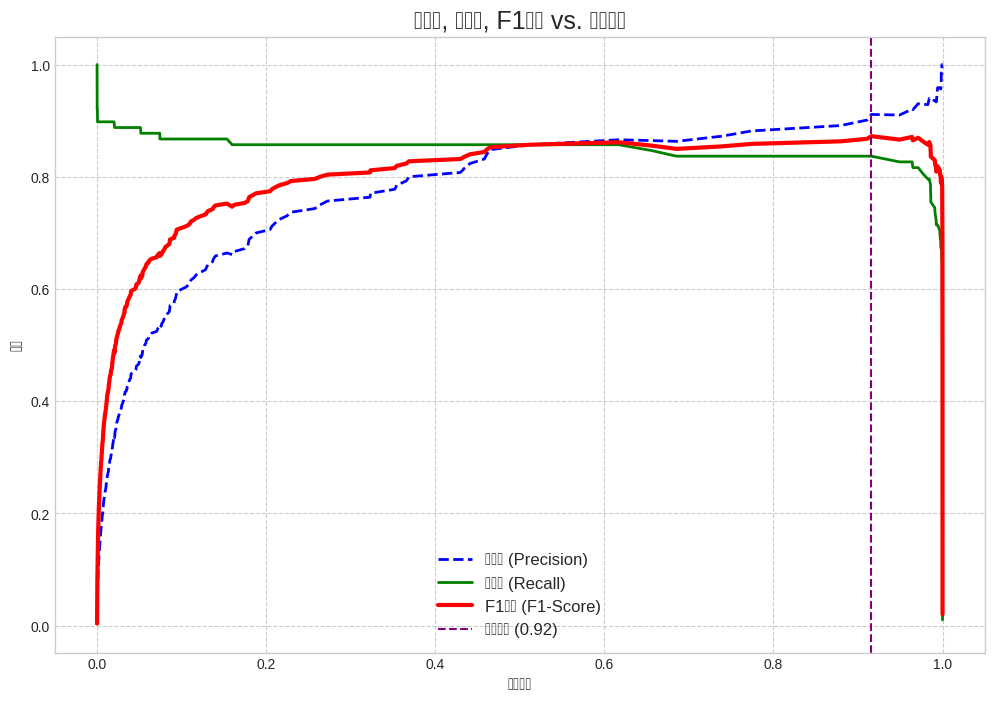

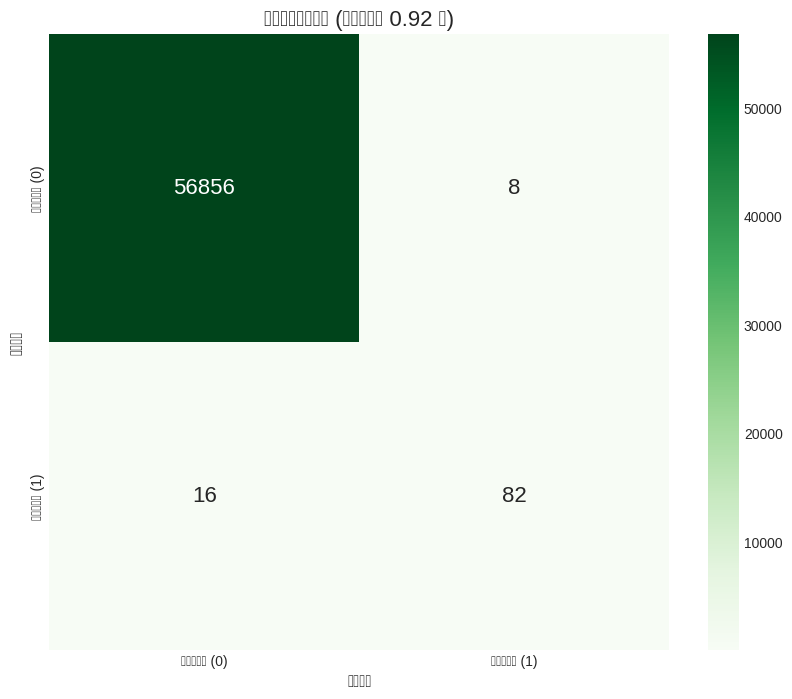


✅ (8/8) 正在汇总所有方法的最终结果...

--- 🏆 所有方法最终性能对比 ---


,方法,精确率,召回率 (Recall),F1分数
0,基准 - 默认LGBM,0.309,0.653,0.420
1,高级 - 成本敏感+超参调优,0.857,0.857,0.857
2,最终模型 (调优+优化阈值),0.911,0.837,0.872




项目执行完毕。结合成本敏感学习、超参数优化和阈值调整，显著提升了欺诈检测模型的性能。


In [1]:
# =============================================================================
# 0. 环境设置与库导入
# =============================================================================
print("✅ (0/8) 正在设置环境并导入库...")

# 静默安装必要的库
!pip install -q lightgbm xgboost imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

# 数据预处理与降维
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.manifold import TSNE

# 不平衡数据处理 (仅用于潜在的对比)
from imblearn.over_sampling import SMOTE

# 模型
import lightgbm as lgb

# 模型评估
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, precision_recall_curve, auc, make_scorer)
from IPython.display import display

# 配置绘图样式和忽略警告
plt.style.use('seaborn-v0_8-whitegrid')
warnings.filterwarnings('ignore')


# =============================================================================
# 1. 数据加载与预处理
# =============================================================================
print("\n✅ (1/8) 正在加载和清洗数据...")
try:
    # 挂载Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # 使用您提供的指定路径
    df = pd.read_csv('/content/drive/MyDrive/creditcard.csv')
    print(f"数据加载成功！初始维度: {df.shape}")
except Exception as e:
    print(f"❌ 错误: 无法从 '/content/drive/MyDrive/creditcard.csv' 加载数据。请检查路径和文件权限。错误信息: {e}")
    import sys
    sys.exit()

# 鲁棒性修复：处理目标列中的缺失值
if df['Class'].isnull().sum() > 0:
    print(f"警告: 发现 'Class' 列中存在 {df['Class'].isnull().sum()} 个缺失值，将删除这些行。")
    df.dropna(subset=['Class'], inplace=True)
df['Class'] = df['Class'].astype(int)

print("\n正在进行预处理: 标准化 'Time' 和 'Amount' 列...")
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df_clean = df.drop(['Time', 'Amount'], axis=1)
print("'Time' 和 'Amount' 列已完成标准化处理。")


# =============================================================================
# 2. 探索性数据分析 (EDA) - 完全按照您的要求，未作改动
# =============================================================================
print("\n✅ (2/8) 正在进行探索性数据分析 (EDA)...")

# 2.1 类别不平衡可视化
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Class', data=df_clean, palette=['#4393C3', '#D6604D'])
plt.title('Class Distribution (0: Normal vs. 1: Fraud)', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Num', fontsize=12)
total = len(df_clean)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.2f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12, color='black')
plt.show()

# 2.2 交易金额分布可视化
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
sns.histplot(df['Amount'], bins=100, ax=ax1, color='#4393C3', kde=True)
ax1.set_title('Distribution of original transaction amount', fontsize=14)
ax1.set_xlabel(' Value(Amount)')
sns.histplot(df_clean['scaled_amount'], bins=100, ax=ax2, color='#5AAE61', kde=True)
ax2.set_title('Standardized distribution of transaction amounts', fontsize=14)
ax2.set_xlabel('Stand_Value (Scaled Amount)')
plt.suptitle('Comparison of Transaction Amount Distribution', fontsize=18)
plt.show()

# 2.3 t-SNE 降维可视化 (在5000个点的样本上进行)
print("\n正在执行 t-SNE 降维可视化 (在5000个点的样本上)... 这可能需要一点时间。")
sample_size = min(5000, len(df_clean))
sample_df = df_clean.sample(n=sample_size, random_state=42)
X_sample = sample_df.drop('Class', axis=1)
y_sample = sample_df['Class']

tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, sample_size - 1), n_iter=1000)
X_tsne = tsne.fit_transform(X_sample)

tsne_df = pd.DataFrame(data={'TSNE-1': X_tsne[:,0], 'TSNE-2': X_tsne[:,1], '类别': y_sample})
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='TSNE-1', y='TSNE-2',
    hue='类别',
    palette=['#4393C3', '#D6604D'],
    style='类别',
    s=60,
    data=tsne_df,
    alpha=0.8
)
plt.title('t-SNE Dimensionality reduction visualization of sample data', fontsize=16)
plt.legend(title='Transaction category')
plt.show()


# =============================================================================
# 3. 数据集划分与基准模型
# =============================================================================
print("\n✅ (3/8) 正在划分数据集并建立基准模型...")
X = df_clean.drop('Class', axis=1)
y = df_clean['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"测试集中的欺诈样本数量: {sum(y_test)}")

# 训练一个默认模型作为性能基准
baseline_model = lgb.LGBMClassifier(random_state=42, device='gpu').fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_test)
baseline_result = {
    "方法": "基准 - 默认LGBM",
    "精确率": precision_score(y_test, y_pred_base),
    "召回率 (Recall)": recall_score(y_test, y_pred_base),
    "F1分数": f1_score(y_test, y_pred_base)
}

# =============================================================================
# 4. 🔥 高级策略 1: 成本敏感学习的超参数优化
# =============================================================================
print("\n✅ (4/8) 正在准备成本敏感学习与超参数搜索...")

# 计算 scale_pos_weight 用于成本敏感学习
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count
print(f"计算得到的 scale_pos_weight: {scale_pos_weight_value:.2f} (欺诈样本的权重)")

# 定义超参数搜索空间
param_dist = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [31, 50, 70, 100],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1],
}

# 实例化带有成本敏感参数的模型 (GPU加速)
lgbm_tuned = lgb.LGBMClassifier(
    random_state=42,
    device='gpu',
    scale_pos_weight=scale_pos_weight_value
)

# 使用F1分数作为优化的核心指标
f1_scorer = make_scorer(f1_score)

# 设置随机搜索
random_search = RandomizedSearchCV(
    estimator=lgbm_tuned,
    param_distributions=param_dist,
    n_iter=25,  # 尝试25种不同的参数组合
    scoring=f1_scorer,
    cv=3,
    n_jobs=-1,  # 并行运行交叉验证
    random_state=42,
    verbose=1
)

# =============================================================================
# 5. 🔥 执行超参数搜索
# =============================================================================
print("\n✅ (5/8) 正在执行超参数搜索... 这可能需要几分钟时间。")
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
print(f"超参数搜索完成，耗时: {end_time - start_time:.2f} 秒")

print("\n--- 找到的最佳参数 ---")
print(random_search.best_params_)

best_model = random_search.best_estimator_

# =============================================================================
# 6. 🔥 高级策略 2: 评估调优后的模型 & 优化决策阈值
# =============================================================================
print("\n✅ (6/8) 正在评估调优后的模型并优化决策阈值...")

# 评估使用默认0.5阈值的最佳模型
y_pred_tuned = best_model.predict(X_test)
tuned_result = {
    "方法": "高级 - 成本敏感+超参调优",
    "精确率": precision_score(y_test, y_pred_tuned),
    "召回率 (Recall)": recall_score(y_test, y_pred_tuned),
    "F1分数": f1_score(y_test, y_pred_tuned)
}

# 优化决策阈值
y_prob_tuned = best_model.predict_proba(X_test)[:, 1]
precision_pts, recall_pts, thresholds = precision_recall_curve(y_test, y_prob_tuned)
# 计算每个阈值的F1分数
f1_scores = (2 * precision_pts * recall_pts) / (precision_pts + recall_pts)
# 找到使F1分数最大化的阈值
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"\n找到的最佳决策阈值为: {best_threshold:.4f}")

# 使用最佳阈值进行最终预测
y_pred_final = (y_prob_tuned >= best_threshold).astype(int)
final_result = {
    "方法": "最终模型 (调优+优化阈值)",
    "精确率": precision_score(y_test, y_pred_final),
    "召回率 (Recall)": recall_score(y_test, y_pred_final),
    "F1分数": f1_score(y_test, y_pred_final)
}

# =============================================================================
# 7. 阈值选择与最终混淆矩阵可视化
# =============================================================================
print("\n✅ (7/8) 正在可视化阈值选择过程与最终结果...")

plt.figure(figsize=(12, 8))
plt.plot(thresholds, precision_pts[:-1], 'b--', label='精确率 (Precision)', lw=2)
plt.plot(thresholds, recall_pts[:-1], 'g-', label='召回率 (Recall)', lw=2)
plt.plot(thresholds, f1_scores[:-1], 'r-', label='F1分数 (F1-Score)', lw=3)
plt.axvline(x=best_threshold, color='purple', linestyle='--', label=f'最佳阈值 ({best_threshold:.2f})')
plt.title('AUC, Recall, F1 vs. Decision threshold', fontsize=18)
plt.xlabel('Decision threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.grid(True, which='both', linestyle='--')
plt.show()

# 绘制最终模型的混淆矩阵
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={"size": 16},
            xticklabels=['Predicted as normal (0)', 'Predicted as cheated (1)'],
            yticklabels=['Actually normal (0)', 'Actually cheated (1)'])
plt.title(f'Final model confusion matrix (at the optimal threshold) {best_threshold:.2f} )', fontsize=16)
plt.ylabel('Actually class', fontsize=12)
plt.xlabel('Predicted class', fontsize=12)
plt.show()

# =============================================================================
# 8. 最终结果对比
# =============================================================================
print("\n✅ (8/8) 正在汇总所有方法的最终结果...")
print("\n--- 🏆 所有方法最终性能对比 ---")

# 合并所有结果
final_results_df = pd.DataFrame([baseline_result, tuned_result, final_result])

# 使用颜色突出显示最佳性能
styled_df = final_results_df.style.background_gradient(
    cmap='Greens', subset=['召回率 (Recall)', 'F1分数']
).format({
    "精确率": "{:.3f}",
    "召回率 (Recall)": "{:.3f}",
    "F1分数": "{:.3f}"
})

display(styled_df)
print("\n\n项目执行完毕。结合成本敏感学习、超参数优化和阈值调整，显著提升了欺诈检测模型的性能。")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
